# Lesson 4.3 梯度下降(Gradient Descent)基本原理与手动实现

&emsp;&emsp;在上一小节中，我们已经成功的构建了逻辑回归的损失函数，但由于逻辑回归模型本身的特殊性，我们在构造损失函数时无法采用类似SSE的计算思路（此时损失函数不是凸函数），因此最终的损失函数也无法用最小二乘法进行直接求解。当然，这其实也不仅仅是逻辑回归模型的“问题”，对于大多数机器学习模型来说，损失函数都无法直接利用最小二乘法进行求解。此时，就需要我们掌握一些可以针对更为一般函数形式进行最小值求解的优化方法。而在机器学习领域，最为基础、同时也最为通用的方法就是梯度下降算法。

&emsp;&emsp;本节我们将详细讨论梯度下降算法的基本原理和实现方法，并在此基础上尝试对逻辑回归损失函数进行求解。

In [1]:
# 科学计算模块
import numpy as np
import pandas as pd

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

## 一、梯度下降基本原理与学习率

### 1.数据背景与最小二乘法求解

&emsp;&emsp;和此前介绍的极大似然估计法类似，梯度下降算法本身也属于数学理论推导相对复杂，但实际应用过程并不难理解的一种方法。因此，我们将先从一个简单的例子入手，通过和最小二乘法计算过程对比，来查看梯度下降的一般过程，然后我们再进行更加严谨的理论推导。

例如，有简单数据集表示如下：

|x|y|
| :------: | :------: |
| 1 | 2 |
| 2 | 4 |
| 3 | 6 |

其中$x$是数据集特征，$y$是数据集标签，假设，我们使用简单线性回归$y = wx$对该组数据进行拟合，则此处我们可以构造损失函数如下：

$$ \begin{align} SSELoss(w)
& = (2-1*w)^2 + (4-2*w)^2 + (6-3*w)^2 \\
& = w^2-4w+4+4w^2-16w+16+9w^2-36w+36 \\
& = 14w^2-56w+56 \\
& = 14(w^2-4w+4)  \\
& = 14(w-2)^2
\end{align} $$

此时，损失函数$SSELoss(w)$就是一个关于w的一元函数。围绕该损失函数进行最小值求解，可考虑使用最小二乘法进行计算，即令$SSELoss(w)$导函数取值为0，此时有：

<center>$ \begin{align} 
\frac{\partial{SSELoss{(w)}}}{\partial{(w)}}  
& = 28(w-2) \\
& = 0  \end{align} $</center>

因此，$w$的最优解为：$$w=2$$

当然，我们也可以通过绘制一个图像来观察损失函数的基本情况：

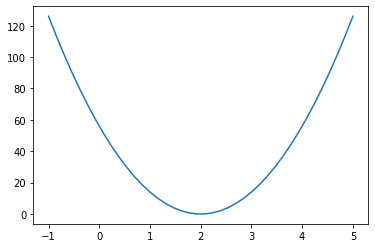

In [5]:
x = np.linspace(-1, 5, 40)
SSELoss = 14 * np.power(x - 2, 2)
plt.plot(x, SSELoss)

### 2.一维梯度下降基本流程

&emsp;&emsp;当然，围绕上述形式非常简单的损失函数，我们也可以尝试使用梯度下降算法进行求解。首先梯度下降算法的目标仍然是求最小值，但和最小二乘法这种一步到位、通过解方程组直接求得最小值的方式不同，梯度下降是通过一种“迭代求解”的方式来进行最小值的求解，其整体求解过程可以粗略描述为，**先随机选取一组参数初始值，然后沿着某个方向，一步一步移动到最小值点**。例如：

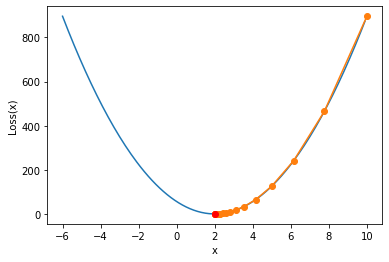

In [9]:
show_trace(gd(lr = 0.01))
plt.plot(2, 0, 'ro')

> 该图像的绘制函数会在稍后的内容中进行讲解

#### 2.1 参数移动第一步

对照上述例子，我们可以将参数的第一次移动过程拆分为以下三步：

- Step 1.随机选取初始参数值

&emsp;&emsp;在上述例子中，参数只有一个，我们可以随机设置一个初始的参数值，例如我们令$w_0=10$。

- Step 2.基于$w_0$，确定参数移动方向

&emsp;&emsp;在上述例子中，由于参数组只有一个参数$w$，因此参数的变化只有两个方向，$w$增加的方向和$w$减少的方向。在梯度下降中，参数移动的目标是让损失函数取值减少，因此在上例中，由于$w$初始取值为10，所以应该沿着$w$减少的方向移动。

> 注意，如果损失函数包含多个参数的话，参数组变化方向就有多个，例如假设参数组包含两个参数$w=(a,b)$，则$w$的变化就相当于是在$(a, b)$这个二维平面上的点发生移动。

**梯度的基本概念**

&emsp;&emsp;当然，在实际计算过程中我们肯定无法通过观察来确定参数移动的方向，为确定更为一般情况下参数的移动方向，我们需要回顾Lesson 2中所介绍的关于梯度向量的相关概念。Lesson 2中我们曾提及，设$f(x)$是一个关于$x$的函数，其中$x$是向量变元，并且$$x = [x_1, x_2,...,x_n]^T$$

则$$\frac{\partial f}{\partial x} = [\frac{\partial f}{\partial x_1}, 
\frac{\partial f}{\partial x_2}, ...,
\frac{\partial f}{\partial x_n}]^T$$

而该表达式也被称为向量求导的梯度向量形式。

$$\nabla _xf(x) = \frac{\partial f}{\partial x} = [\frac{\partial f}{\partial x_1}, 
\frac{\partial f}{\partial x_2}, ...,
\frac{\partial f}{\partial x_n}]^T$$

进一步的，如果假设$f(x)$是关于参数$x$的损失函数，则$\nabla _xf(x)$就是损失函数的梯度向量，或者梯度表达式。而当损失函数的参数$x$选定一组取值之后，我们就能计算梯度表达式的取值，该值也被称为损失函数在某组参数取值下的梯度。

&emsp;&emsp;例如，在上例中，损失函数$$f(w) = 14(w-2)^2$$

损失函数的梯度向量表示形式为：$$\nabla _wf(w) = \frac{\partial f}{\partial w}=28(w-2)$$

具体来看，当$w_0=10$时，梯度计算结果为$$\nabla _wf(w_0)=28(10-2)=28*8=224$$

在确定了梯度之后，接下来参数的移动方向也随之确定，在梯度下降算法中，参数的移动方向是梯度的负方向。

&emsp;&emsp;注意，这里有两点需要注意，其一是梯度的负方向，上述计算结果中，224既是梯度的取值，同时也代表着梯度的方向——正方向。而此时梯度的负方向则是取值减少的方向，和损失函数图像观测结果相同。其二是参数的移动是朝着梯度的负方向移动，也就是朝着数值减少的方向移动，而不是直接在原参数10的基础上减去224，这很明显是不合适的。

> 对于只包含一个变量的损失函数来说，梯度也就是函数某点的导数。

- Step 3.确定移动步长并进行移动

&emsp;&emsp;在确定移动的方向之后，接下来需要进一步确定移动距离。在梯度下降中，我们采用梯度乘以某个人工设置的参数作为每一步移动的距离，这个参数被称为步长或者学习率（Learning rate），例如在上述案例中，我们可以设置学习率为lr = 0.01，则从$w_0$进行移动的距离是$0.01 * 224 = 2.24$，而又是朝向梯度的负方向进行移动，因此$w_0$最终移动到了$w_1 = 10-2.24 = 7.76$

> 相比于步长，将人工设置的参数称为学习率会更加贴切，该参数并不代表真实移动的距离，而是影响真实移动距离的一个“比率”，或者说是真实移动距离学习梯度值的“比率”。

至此，参数$w$就完成了第一次移动，$w_0 \rightarrow w_1$。

#### 2.2 梯度下降的多轮迭代

&emsp;&emsp;当然，$w$从$w_0$移动到$w_1$其实只移动了一步，要最终抵达损失函数的最小值点$w=2$，还有很长一段距离，因此我们还需要移动多次。参数多次移动过程中的每一步其实都是在重复上述三个步骤。例如，当我们需要第二次移动$w$时，过程如下：

$$w_2 = w_1 - lr \cdot \nabla _wf(w_1)$$

即$w_2$等于$w_1$沿着$w_1$的负梯度方向移动了$lr\cdot\nabla _wf(w_1)$距离之后得到的结果。此时我们是在$w_1$的基础上，减去学习率和$w_1$梯度的乘积。

&emsp;&emsp;当然，依此类推，当从$w_{(n-1)}$移动到$w_n$时$w_n$的计算公式如下：

$$w_n = w_{(n-1)} - lr \cdot \nabla _wf(w_{(n-1)})$$

并且，我们可以称从$w_0$移动到$w_1$是第一轮迭代，从$w_1$移动到$w_2$是第二轮迭代，从$w_{(n-1)}$移动到$w_n$是第n轮迭代。

> 迭代其实是一个数学意义上的概念，一般指以下计算流程：某次运算时初始条件是上一次运算的结果，而当前运算的结果则是下一次计算的初始条件。

&emsp;&emsp;而通过带入梯度值进行多轮迭代，最终使得损失函数的取值逐渐下降的算法，就被称为梯度下降。

### 2.梯度下降算法特性与学习率

&emsp;&emsp;首先，我们简单验证，经过上述梯度下降的一系列计算，最终能否有效降低损失函数的计算结果，即使得$w$最终朝向最优值2靠拢。我们可以通过定义一个函数来帮助我们进行梯度下降迭代计算。

In [2]:
def gd(lr = 0.02, itera_times = 20, w = 10):
    """
    梯度下降计算函数
    :param lr: 学习率
    :param itera_times：迭代次数
    :param w：参数初始取值
    :return results：每一轮迭代的参数计算结果列表
    """                              
    results = [w]
    for i in range(itera_times):
        w -= lr * 28 * (w - 2)            # 梯度计算公式
        results.append(w)
    return results

当我们在以0.02作为学习率，初始值为10，迭代20轮时参数每一轮迭代后参数的计算结果如下：

In [6]:
res = gd()
res

[10,
 5.52,
 3.5488,
 2.681472,
 2.29984768,
 2.1319329792,
 2.058050510848,
 2.02554222477312,
 2.0112385789001728,
 2.004944974716076,
 2.0021757888750735,
 2.0009573471050324,
 2.000421232726214,
 2.000185342399534,
 2.000081550655795,
 2.00003588228855,
 2.000015788206962,
 2.0000069468110633,
 2.000003056596868,
 2.000001344902622,
 2.000000591757154]

我们发现，参数从10开始朝向2移动，并且迭代20轮时已经非常接近全域最优解2，此处也验证梯度下降确实能够帮助我们找到最优解。当然，我们也可以将上述参数移动过程和损失函数的函数图像绘制到一张画布上，具体功能可以通过如下函数实现：

In [3]:
def show_trace(res):
    """
    梯度下降轨迹绘制函数
    """
    f_line = np.arange(-6, 10, 0.1)
    plt.plot(f_line, [14 * np.power(x-2, 2) for x in f_line])
    plt.plot(res, [14 * np.power(x-2, 2) for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('Loss(x)')

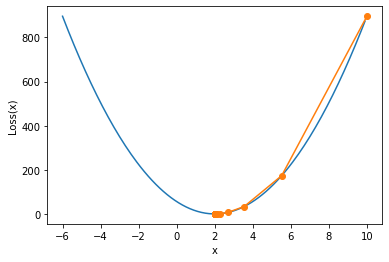

In [7]:
show_trace(res)

&emsp;&emsp;接下来，我们在此基础之上，详细讨论梯度下降算法的基本特性与超参数取值一般规范。

&emsp;&emsp;从图像上，我们发现，梯度下降的计算过程中，刚开始$w$变化非常快，而随着逐渐接近最小值点$w$的变化幅度逐渐减少，也就是说，梯度下降其实并不是一个等步长的移动过程。当然，根据梯度下降的计算公式，$w_{(n-1)}$和$w_{n}$的差值是：

$$|w_n - w_{(n-1)}| =  |lr \cdot \nabla _wf(w_{(n-1)})|$$

而lr又是一个恒定的数值，那么也就是说，每个点的梯度值是不一样的（哪怕梯度方向一样），并且越靠近最小值点梯度值越小，当然这点从梯度计算公式也能看出：

$$\nabla _wf(w) = \frac{\partial f}{\partial w}=28(w-2)$$

当然，这也就等价说明，如果某点的梯度值相对较大，那么该点应该距离全域最小值较远。而梯度下降过程中实际也能够做到在远点迭代移动距离较大、近点迭代移动距离较小。当然，在学习率对移动距离进行修正时，学习率不宜设置过小，也不宜设置过大，例如当学习率设置过小时：

<AxesSubplot:>

Text(0.5, 1.0, 'lr=0.001')

<AxesSubplot:>

Text(0.5, 1.0, 'lr=0.01')

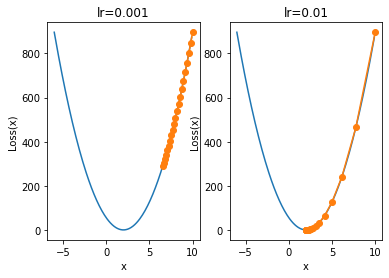

In [12]:
plt.subplot(121)
plt.title('lr=0.001')
show_trace(gd(lr=0.001))
plt.subplot(122)
plt.title('lr=0.01')
show_trace(gd(lr=0.01))

当学习率取值为0.001时，迭代20轮仍然距离最小值点差距较远，此时我们考虑进一步增加迭代次数：

<AxesSubplot:>

Text(0.5, 1.0, 'itera_times=20')

<AxesSubplot:>

Text(0.5, 1.0, 'itera_times=40')

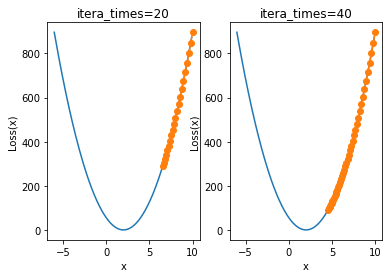

In [20]:
plt.subplot(121)
plt.title('itera_times=20')
show_trace(gd(itera_times=20, lr=0.001))
plt.subplot(122)
plt.title('itera_times=40')
show_trace(gd(itera_times=40, lr=0.001))

<AxesSubplot:>

Text(0.5, 1.0, 'itera_times=60')

<AxesSubplot:>

Text(0.5, 1.0, 'itera_times=80')

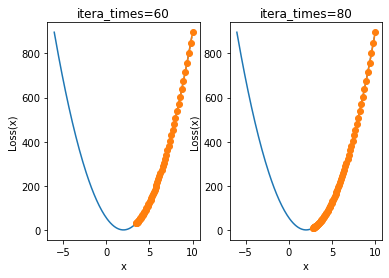

In [21]:
plt.subplot(121)
plt.title('itera_times=60')
show_trace(gd(itera_times=60, lr=0.001))
plt.subplot(122)
plt.title('itera_times=80')
show_trace(gd(itera_times=80, lr=0.001))

此处学习率为0.001取值的情况下，迭代次数增加了三倍但仍然没有收敛到2附近，需要迭代80次左右才能收敛至较好效果。而过多次的迭代会增加额外计算量，也就是说如果学习率取值较小，则会耗费更多的计算量。

&emsp;&emsp;接下来我们再来看当学习率取值过大时可能出现的状况。当我们将学习率设置为0.05时，迭代过程如下所示：

<AxesSubplot:>

Text(0.5, 1.0, 'lr=0.01')

<AxesSubplot:>

Text(0.5, 1.0, 'lr=0.05')

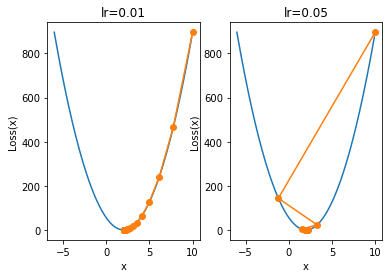

In [47]:
plt.subplot(121)
plt.title('lr=0.01')
show_trace(gd(lr=0.01))
plt.subplot(122)
plt.title('lr=0.05')
show_trace(gd(lr=0.05))

我们发现当学习率较大时，收敛过程并不平稳，当然小幅度不平稳并不影响最终收敛结果，但学习率继续增加，例如我们将学习率增加至0.08时，参数整体迭代过程不仅不会收敛，而且还会逐渐发散：

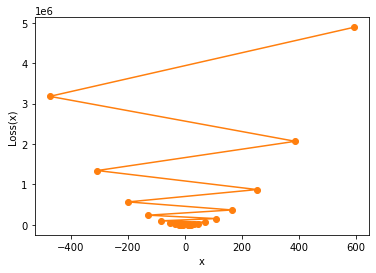

In [45]:
show_trace(gd(lr=0.08))

In [46]:
gd(lr=0.08)

[10,
 -7.920000000000002,
 14.300800000000006,
 -13.25299200000001,
 20.913710080000012,
 -21.45300049920002,
 31.081720619008028,
 -34.06133356756996,
 46.71605362378676,
 -53.447906493495594,
 70.75540405193455,
 -83.25670102439885,
 107.71830927025458,
 -129.0907034951157,
 164.55247233394346,
 -199.56506569408992,
 251.94068146067156,
 -307.92644501123283,
 386.30879181392874,
 -474.5429018492717,
 592.9131982930971]

由此我们不难发现学习率取值是影响结果是否收敛、以及能否在有限次迭代次数中高效收敛的关键参数。学习率过大会导致结果发散，而学习率过小则又会导致模型无法收敛至最优结果。更多关于学习率参数调整策略，我们会在后续建模环节中逐步介绍。

> **不同损失函数选取方式或者数值处理方法对梯度下降过程中移动距离的影响相关讨论**     
&emsp;&emsp;这里需要知道的是，影响迭代收敛结果的是每一步移动的真实距离，而移动的真实距离又和学习率和梯度二者相关，有的时候我们可以通过一些数值处理手段等比例缩小梯度，此时学习率就可以稍微设置大些。例如此处如果我们采用MSE计算公式作为损失函数，则梯度计算公式就由原先的$28(w-2)$变为了$\frac{28(w-2)}{3}$（总共三条样本，$MSE=\frac{SSE}{3}$）。而此时就相当于梯度减少至原先的1/3，在学习率不变的情况下，每次移动的距离也将减少至原先的1/3。而在另外一种情况下，也就是例如数据归一化，即对带入的数据进行数值调整的一种方法（后续会介绍）。如果带入损失函数计算的数值大幅减少，则最终的梯度也会受其影响，数值也会有所减少，此时同样在学习率不变的情况下每次移动的距离也会减少。

> **移动距离衰减**      
此外，此处还有一个重要结论，那就是参数点越远离最小值点，参数点的梯度就相对较大，此时每次迭代移动的距离就相对较大，而如果参数点比较靠近最小值点，此时梯度取值较小，每次移动的距离就比较小。而当已经非常接近最小值点时，每次移动的距离就会变得非常小，因此我们其实无论增加多少轮迭代，只要参数不会发散，最终参数值点都不可能“跨过”最小值点。

## 二、梯度下降一般建模流程与多维梯度下降

### 1.多维梯度下降与损失函数可视化

&emsp;&emsp;一种更为一般的情况是，一个模型中包含多个参数，而损失函数就是这多个参数共同构成的函数。例如在Lesson 1中我们曾利用带截距项的简单线性回归$y=wx+b$对下述数据进行拟合，并得出带有两个参数的损失函数：

|数据特征|参数组|模型输出|数据标签|      
|:--:|:--:|:--:|:--:|   
|Whole weight(x)|$(w,b)$|$\hat y$|Rings(y)|    
|1|(w, b)|w+b|2|
|3|(w, b)|3w+b|4|

$$SSELoss(w, b) = (y_1 - ŷ_1)^2 + (y_2 - ŷ_2)^2 = (2 - w - b)^2 + (4 - 3w - b)^2$$

而此时损失函数图像就是包含两个变量的三维图像

In [69]:
from mpl_toolkits.mplot3d import Axes3D

In [6]:
x = np.arange(-1,3,0.05)
y = np.arange(-1,3,0.05)
w, b = np.meshgrid(x, y)
SSE = (2 - w - b) ** 2 + (4 - 3 * w - b) ** 2

Text(0.5, 0, 'w')

Text(0.5, 0, 'b')

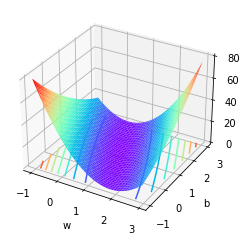

In [7]:
ax = plt.axes(projection='3d')

ax.plot_surface(w, b, SSE, cmap='rainbow')
ax.contour(w, b, SSE, zdir='z', offset=0, cmap="rainbow")  #生成z方向投影，投到x-y平面
plt.xlabel('w')
plt.ylabel('b')
plt.show()

并且，我们通过最小二乘法能够找出全域最小值点为(1,1)，也就是当$w=1,b=1$时，能够让损失函数取值最小。当然，围绕该问题，我们也可以采用梯度下降进行最优解求解。

### 2.梯度下降计算流程

&emsp;&emsp;此处给出更加严谨的梯度下降实现步骤：

- Step 1.确定数据及模型

&emsp;&emsp;首先还是要明确数据和模型，然后才能进一步确定参数、梯度计算公式等变量。此处我们以$y=wx+b$简单线性回归对上述简单数据集进行拟合，参数向量包含两个分量。

- Step 2.设置初始参数值

&emsp;&emsp;然后我们需要选取一组参数值，一种更加通用的方法，是给初始参数赋予一组随机数作为初始取值。由于参数包含两个分量，因此参数向量的初始值可以由如下过程确定：

In [8]:
np.random.seed(24)
w = np.random.randn(2, 1)                # 参数都默认为列向量
w

array([[ 1.32921217],
       [-0.77003345]])

- Step 3.根据损失函数求出梯度表达式

&emsp;&emsp;只有确定了梯度表达式，才能在后续每一轮迭代过程中快速计算梯度。线性回归的损失函数是围绕SSE及其衍生的指标所构建的损失函数，此处以MSE作为损失函数的构建指标，此处可借助已经定义好的SSELoss函数执行计算。

$$SSELoss(\hat w) = ||y - X\hat w||_2^2 = (y - X\hat w)^T(y - X\hat w)$$

$$MSELoss(\hat w) = \frac{||y - X\hat w||_2^2}{m} = \frac{(y - X\hat w)^T(y - X\hat w)}{m}$$

其中m为训练数据总数。

In [2]:
def MSELoss(X, w, y):
    """
    MSE指标计算函数
    """
    SSE = SSELoss(X, w, y)
    MSE = SSE / X.shape[0]
    return MSE

此时数据为：

In [3]:
features = np.array([1, 3]).reshape(-1, 1)
features = np.concatenate((features, np.ones_like(features)), axis=1)

In [4]:
features

array([[1, 1],
       [3, 1]])

In [5]:
labels = np.array([2, 4]).reshape(-1, 1)
labels

array([[2],
       [4]])

In [9]:
# 计算w取值时SSE
SSELoss(features, w, labels)

array([[2.68811092]])

In [10]:
# 计算w取值时MSE
MSELoss(features, w, labels)

array([[1.34405546]])

而对于线性回归损失函数梯度表达式，则可根据Lesson 2中线性回归损失函数梯度求导结果得出：

$$\begin{aligned}
\frac{SSELoss(\hat w)}{\partial{\boldsymbol{\hat w}}} 
&= \frac{\partial{||\boldsymbol{y} - \boldsymbol{X\hat w}||_2}^2}{\partial{\boldsymbol{\hat w}}}
\\
&= \frac{\partial(\boldsymbol{y} - \boldsymbol{X\hat w})^T(\boldsymbol{y} - \boldsymbol{X\hat w})}{\partial{\boldsymbol{\hat w}}} \\
& =\frac{\partial(\boldsymbol{y}^T - \boldsymbol{\hat w^T X^T})(\boldsymbol{y} - \boldsymbol{X\hat w})}{\partial{\boldsymbol{\hat w}}}\\
&=\frac{\partial(\boldsymbol{y}^T\boldsymbol{y} - \boldsymbol{\hat w^T X^Ty}-\boldsymbol{y}^T\boldsymbol{X \hat w} +\boldsymbol{\hat w^TX^T}\boldsymbol{X\hat w})}{\partial{\boldsymbol{\hat w}}}\\ 
& = 0 - \boldsymbol{X^Ty} - \boldsymbol{X^Ty}+X^TX\hat w+(X^TX)^T\hat w \\
&= 0 - \boldsymbol{X^Ty} - \boldsymbol{X^Ty} + 2\boldsymbol{X^TX\hat w}\\
&= 2(\boldsymbol{X^TX\hat w} - \boldsymbol{X^Ty}) \\
&= 2X^T(X\hat w -y)
\end{aligned}$$

此处我们使用MSE作为损失函数，则该损失函数的梯度表达式为：

$$
\frac{MSELoss(\hat w)}{\partial{\boldsymbol{\hat w}}} = \frac{2X^T(X\hat w -y)}{m}
$$

> 注：矩阵运算也是可以提取公因式的

据此我们可以定义线性回归的梯度计算函数

In [11]:
def lr_gd(X, w, y):
    """
    线性回归梯度计算公式
    """
    m = X.shape[0]
    grad = 2 * X.T.dot((X.dot(w) - y)) / m
    return grad

In [12]:
# 计算w取值时梯度
lr_gd(features, w, labels)

array([[-3.78801208],
       [-2.22321821]])

> 该步骤其实也是在手动实现梯度下降计算过程中至关重要的一步，正如此前所介绍的，只有将方程组转化为矩阵形式，才能更好的利用程序进行计算。但值得注意的是，并不是所有的损失函数的梯度计算都能简单表示成矩阵运算形式。

- Step 4.执行梯度下降迭代

&emsp;&emsp;在给定梯度计算公式和参数初始值的情况下，我们就能够开始进行梯度下降迭代计算了。在梯度下降过程中，参数更新参照如下公式：

$$w_n = w_{(n-1)} - lr \cdot \nabla _wf(w_{(n-1)})$$

则可定义相应函数：

In [13]:
def w_cal(X, w, y, gd_cal, lr = 0.02, itera_times = 20):
    """
    梯度下降中参数更新函数 
    :param X: 训练数据特征
    :param w: 初始参数取值
    :param y: 训练数据标签
    :param gd_cal：梯度计算公式
    :param lr: 学习率
    :param itera_times: 迭代次数       
    :return w：最终参数计算结果   
    """
    for i in range(itera_times):
        w -= lr * gd_cal(X, w, y)
    return w

接下来执行梯度下降计算，在学习率为0.1的情况下迭代100轮：

In [18]:
np.random.seed(24)
w = np.random.randn(2, 1)                # 参数都默认为列向量
w

array([[ 1.32921217],
       [-0.77003345]])

In [19]:
w = w_cal(features, w, labels, gd_cal = lr_gd, lr = 0.1, itera_times = 100)
w

array([[1.02052278],
       [0.95045363]])

In [20]:
# 计算w取值时SSE
SSELoss(features, w, labels)

array([[0.0009869]])

In [21]:
# 计算w取值时MSE
MSELoss(features, w, labels)

array([[0.00049345]])

In [22]:
# 计算w取值时梯度
lr_gd(features, w, labels)

array([[ 0.0070423 ],
       [-0.01700163]])

我们发现，最终参数结果逼近(1,1)点，也就是说整体计算过程能够在迭代多轮之后逼近全域最小值点。据此也验证了梯度下降本身的有效性。当然，此处是以二维梯度下降为例进行的展示，更高维度的梯度下降过程也是类似，并且可以借助NumPy当中数组的优秀性质来完成相关梯度的计算。

### 3.二维梯度下降过程的可视化展示

#### 3.1 等高线图

&emsp;&emsp;为了方便后续其他梯度下降算法的性质展示，我们通过绘制损失函数的等高线图来观察二维梯度下降过程中参数点移动的过程。首先在上述迭代100次的过程中，我们可以记录每一次迭代的计算结果：

In [23]:
def w_cal_rec(X, w, y, gd_cal, lr = 0.02, itera_times = 20):
    w_res = [np.copy(w)]
    for i in range(itera_times):
        w -= lr * gd_cal(X, w, y)
        w_res.append(np.copy(w))
    return w, w_res

In [24]:
np.random.seed(24)
w = np.random.randn(2, 1)

In [25]:
w, w_res = w_cal_rec(features, w, labels, gd_cal = lr_gd, lr = 0.1, itera_times = 100)

In [26]:
w_res

[array([[ 1.32921217],
        [-0.77003345]]),
 array([[ 1.70801338],
        [-0.54771163]]),
 array([[ 1.61908465],
        [-0.52137466]]),
 array([[ 1.60854986],
        [-0.46473359]]),
 array([[ 1.58589343],
        [-0.41520681]]),
 array([[ 1.56608273],
        [-0.36652283]]),
 array([[ 1.54660913],
        [-0.31965135]]),
 array([[ 1.52786054],
        [-0.27436473]]),
 array([[ 1.50974589],
        [-0.230636  ]]),
 array([[ 1.4922544 ],
        [-0.18840716]]),
 array([[ 1.47536286],
        [-0.14762749]]),
 array([[ 1.45905099],
        [-0.10824714]]),
 array([[ 1.44329885],
        [-0.07021811]]),
 array([[ 1.42808724],
        [-0.03349403]]),
 array([[1.41339761],
        [0.00196988]]),
 array([[1.39921205],
        [0.03621686]]),
 array([[1.38551326],
        [0.06928867]]),
 array([[1.37228453],
        [0.10122563]]),
 array([[1.35950975],
        [0.13206669]]),
 array([[1.34717332],
        [0.16184946]]),
 array([[1.33526022],
        [0.19061024]]),
 array

In [31]:
# 所有点的横坐标
np.array(w_res)[:, 0]

array([[1.32921217],
       [1.70801338],
       [1.61908465],
       [1.60854986],
       [1.58589343],
       [1.56608273],
       [1.54660913],
       [1.52786054],
       [1.50974589],
       [1.4922544 ],
       [1.47536286],
       [1.45905099],
       [1.44329885],
       [1.42808724],
       [1.41339761],
       [1.39921205],
       [1.38551326],
       [1.37228453],
       [1.35950975],
       [1.34717332],
       [1.33526022],
       [1.32375591],
       [1.31264636],
       [1.30191803],
       [1.29155784],
       [1.28155316],
       [1.27189178],
       [1.26256193],
       [1.25355223],
       [1.24485169],
       [1.23644971],
       [1.22833604],
       [1.22050079],
       [1.2129344 ],
       [1.20562764],
       [1.19857162],
       [1.19175772],
       [1.18517763],
       [1.17882334],
       [1.17268709],
       [1.16676141],
       [1.16103906],
       [1.15551307],
       [1.15017671],
       [1.14502346],
       [1.14004704],
       [1.13524139],
       [1.130

- 参数移动轨迹图

据此我们可以将所有点在迭代过程的移动轨迹绘制在图片上：

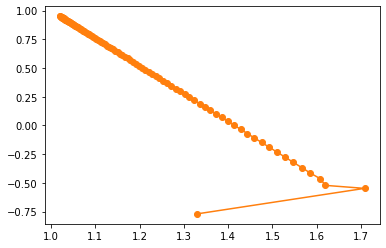

In [221]:
plt.plot(np.array(w_res)[:, 0], np.array(w_res)[:, 1], '-o', color='#ff7f0e')

> 更多关于matplotlib绘图中色卡及对应参数选择，详见：[https://blog.csdn.net/weixin_30369087/article/details/94971393]

&emsp;&emsp;我们发现，参数在参数平面上的移动轨迹其实并不是一条直线。当然，我们也可以通过等高线图来观察参数点逼近(1,1)点的移动情况。

In [233]:
# 网格点坐标
x1, x2 = np.meshgrid(np.arange(1, 2, 0.001), np.arange(-1, 1, 0.001))

其中np.meshgrid生成两个序列，第一个序列根据输入的第一个参数按照列排列，第二个序列根据输入的第二个参数按行排列。该函数输出结果主要用于带网格的图像绘制情况。

In [32]:
np.meshgrid(np.arange(3), np.arange(1, 5))

[array([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]]),
 array([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4]])]

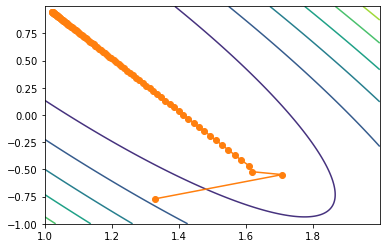

In [235]:
# 绘制等高线图
plt.contour(x1, x2, (2-x1-x2)**2+(4-3*x1-x2)**2)

# 绘制参数点移动轨迹图
plt.plot(np.array(w_res)[:, 0], np.array(w_res)[:, 1], '-o', color='#ff7f0e')

其中，等高线图要求输入网格的范围和间隔（即x1和x2），以及输入对应函数关系（即x1和x2二者作为自变量的函数表达式）。

#### 3.2 损失函数取值变化图

&emsp;&emsp;从一个更加严谨的角度，我们可以绘制其损失函数变化曲线：

In [240]:
loss_value = np.array([MSELoss(features, np.array(w), labels) for w in w_res]).flatten()

In [244]:
loss_value

array([1.34405546e+00, 5.18623852e-01, 4.63471078e-01, 4.31655465e-01,
       4.02524386e-01, 3.75373031e-01, 3.50053485e-01, 3.26441796e-01,
       3.04422755e-01, 2.83888935e-01, 2.64740155e-01, 2.46882992e-01,
       2.30230325e-01, 2.14700907e-01, 2.00218974e-01, 1.86713872e-01,
       1.74119712e-01, 1.62375048e-01, 1.51422581e-01, 1.41208877e-01,
       1.31684104e-01, 1.22801792e-01, 1.14518608e-01, 1.06794137e-01,
       9.95906956e-02, 9.28731379e-02, 8.66086905e-02, 8.07667906e-02,
       7.53189365e-02, 7.02385492e-02, 6.55008424e-02, 6.10827019e-02,
       5.69625722e-02, 5.31203522e-02, 4.95372963e-02, 4.61959234e-02,
       4.30799317e-02, 4.01741188e-02, 3.74643078e-02, 3.49372780e-02,
       3.25807006e-02, 3.03830783e-02, 2.83336892e-02, 2.64225348e-02,
       2.46402910e-02, 2.29782625e-02, 2.14283405e-02, 1.99829634e-02,
       1.86350793e-02, 1.73781123e-02, 1.62059298e-02, 1.51128129e-02,
       1.40934286e-02, 1.31428034e-02, 1.22562995e-02, 1.14295918e-02,
      

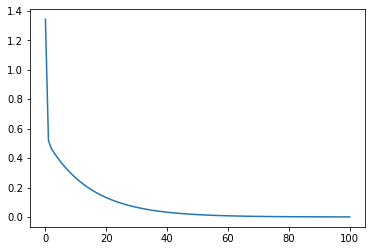

In [241]:
plt.plot(np.arange(101), loss_value)

&emsp;&emsp;能够发现，在梯度下降过程中损失值是严格递减的。当然我们也可以将上述过程分装为一个函数：

In [246]:
def loss_vis(X, w_res, y, loss_func):
    loss_value = np.array([loss_func(X, np.array(w), y) for w in w_res]).flatten()
    plt.plot(np.arange(len(loss_value)), loss_value)

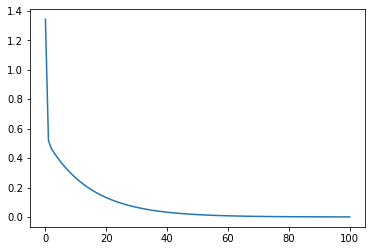

In [248]:
# 验证函数是否可执行
loss_vis(features, w_res, labels, MSELoss)

### 4.线性回归的梯度下降求解过程

&emsp;&emsp;在掌握梯度下降基本原理即基本性质之后，我们可以尝试在手动创建的线性回归数据集上进行梯度下降方法的参数求解。还是围绕Lesson 3.3中的数据集进行线性回归参数求解，梯度下降求解过程仍然按照上述过程执行：

- Step 1.确定数据集和模型

&emsp;&emsp;仍然还是创建扰动项不大、基本满足$y=2x_1-x_2+1$规律的数据集。

In [249]:
# 设置随机数种子
np.random.seed(24)   

# 扰动项取值为0.01
features, labels = arrayGenReg(delta=0.01)

- Step 2.设置初始参数

In [250]:
np.random.seed(24)  
w = np.random.randn(3, 1)
w

array([[ 1.32921217],
       [-0.77003345],
       [-0.31628036]])

- Step 3.构建损失函数与梯度表达式

In [251]:
# 计算w取值时SSE
SSELoss(features, w, labels)

array([[2093.52940481]])

In [252]:
# 计算w取值时MSE
MSELoss(features, w, labels)

array([[2.0935294]])

In [253]:
# 计算w取值时梯度
lr_gd(features, w, labels)

array([[-1.15082596],
       [ 0.3808195 ],
       [-2.52877477]])

- Step 4.执行梯度下降计算

&emsp;&emsp;接下来，借助此前所定义的参数更新函数进行梯度下降参数求解：

In [254]:
w = w_cal(features, w, labels, gd_cal = lr_gd, lr = 0.1, itera_times = 100)
w

array([[ 1.99961892],
       [-0.99985281],
       [ 0.99970541]])

In [255]:
# 计算w取值时SSE
SSELoss(features, w, labels)

array([[0.09300731]])

In [256]:
# 计算w取值时MSE
MSELoss(features, w, labels)

array([[9.30073138e-05]])

&emsp;&emsp;至此，我们就完成了梯度下降算法的手动实现过程。

## 三、梯度下降算法评价

### 1.梯度下降算法优势

&emsp;&emsp;本节我们以线性回归的损失函数构建了梯度表达式来进行梯度下降的计算，尽管线性回归的损失函数可以用最小二乘法直接进行求解，但梯度下降算法在某些场景下仍然具备一定优势，这些优势主要体现在两个方面，其一是相比大规模数值矩阵运算，梯度下降所遵循的迭代求解效率更高（尽管大规模矩阵运算也可以通过分块矩阵的划分来减少每一次计算的数据量），其二则是对于某些最小二乘法无法计算全域唯一最优解的情况，梯度下降仍然能够有效进行最小值点（或者解空间）的寻找。

> **数值解和解析解**      
对于通过严格数学公式计算得出的结果，类似最小二乘法计算结果，也被称为解析解。而由某种计算方法或者计算流程得出的结果，例如梯度下降算得的结果，也被称为数值解。

### 2.梯度下降算法局限

&emsp;&emsp;但是，对于上述梯度下降算法还是存在一定的局限性。当损失函数不是凸函数时，也就是有可能存在局部最小值或者鞍点时，梯度下降并不一定能够准确找到全域最小值。

#### 2.1 局部最小值点（local minimun）陷阱

&emsp;&emsp;所谓局部最小值，指的是该点左右两端取值都大于该点，但是该点不是全域最小值点。例如函数：

$$f(x)=x\cdot cos(\pi x)$$

该函数函数图像如下：

In [34]:
x = np.arange(-1, 2, 0.1)
y = x * np.cos(np.pi * x)

Text(0, 0.5, 'x·cos(pi·x)')

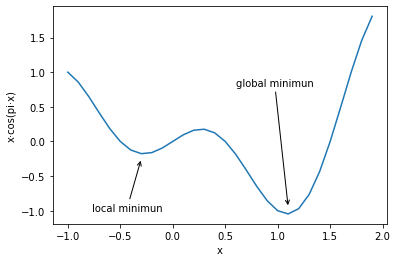

In [35]:
fig = plt.plot(x, y)[0]
fig.axes.annotate('local minimun', xytext=(-0.77, -1), 
                  arrowprops=dict(arrowstyle='->'), xy=(-0.3, -0.25))
fig.axes.annotate('global minimun', xytext=(0.6, 0.8), 
                  arrowprops=dict(arrowstyle='->'), xy=(1.1, -0.95))
plt.xlabel('x')
plt.ylabel('x·cos(pi·x)')

> 注，其中plt.plot(x, y)[0]是返回图像对象，axes.annotate是在图像上添加文字或图形，xytext是文字起始坐标，xy是图形起始坐标。

根据此前所介绍的梯度下降的距离衰减理论，由于局部最小值点梯度也是零，因此如果参数点陷入局部最小值，则不可能跨过局部最小值抵达全域最小值点。假设$f(x)=x\cdot cos(\pi x)$就是此时的损失函数，并且此时存在唯一的参数x，则梯度下降迭代计算有如下过程。

> 注，此处我们在未知数据、模型和评估指标的情况下，直接给出了损失函数。

首先是由损失函数到梯度计算表达式的过程，由于损失函数只有一个参数，所以梯度表达式为$$f'(x) = (x\cdot cos(\pi x))' = cos(\pi x) + x\cdot (-sin(\pi x)) \cdot \pi$$

我们可以定义该函数的函数表达式函数及导函数函数表达式。

In [36]:
def f_1(x):
    return (x*np.cos(np.pi*x))

In [37]:
f_1(-1)

1.0

In [38]:
def f_gd_1(x):
    return (np.cos(np.pi*x)-x*np.pi*(np.sin(np.pi*x)))

In [39]:
f_gd_1(-1)

-1.0000000000000004

以及相应的梯度更新函数

In [40]:
def gd_1(lr = 0.02, itera_times = 20, w = -1):
    """
    梯度下降计算函数
    :param lr: 学习率
    :param itera_times：迭代次数
    :param w：参数初始取值
    :return results：每一轮迭代的参数计算结果列表
    """                              
    results = [w]
    for i in range(itera_times):
        w -= lr * f_gd_1(w)              # 梯度计算公式
        results.append(w)
    return results

当我们在以0.02作为学习率，参数初始值为-1，迭代5000轮时参数每一轮迭代后参数的计算结果如下：

In [43]:
res = gd_1(itera_times = 5000)
res[-1]

-0.2738526868008511

&emsp;&emsp;我们发现，参数最终在停留在-0.27附近。当然，对于上述一维梯度下降，我们也可以绘制对应参数变化的轨迹图来进行观察。

In [41]:
def show_trace_1(res):
    """
    梯度下降轨迹绘制函数
    """
    f_line = np.arange(-1, 2, 0.01)
    plt.plot(f_line, [f_1(x) for x in f_line])
    plt.plot(res, [f_1(x) for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('Loss(x)')

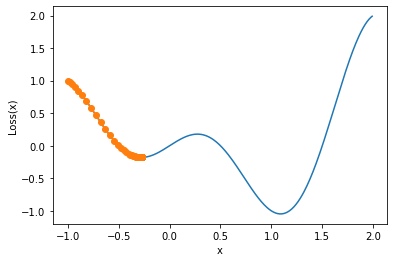

In [42]:
show_trace_1(res)

&emsp;&emsp;我们发现，参数最终停留在局部最小值附近，并且无法跨越该局部最小值点。而根据此前所介绍的梯度下降移动距离衰减理论，最终迭代5000轮之后该点梯度也应该是一个趋于0的值。当然，这也符合局部最小值的特点，导数为0。

In [68]:
f_gd_1(res[-1])

-1.2212453270876722e-15

&emsp;&emsp;当然，对于梯度下降的局部最小值陷阱，根本原因还是在于梯度下降过程中参数移动的距离和梯度直接挂钩，而梯度下降的该特点不仅导致了局部最小值陷阱，还有另外一类更加常见的陷阱——鞍点陷阱。

#### 2.2 鞍点（saddle point）陷阱

&emsp;&emsp;首先让我们来看下什么是鞍点。鞍点有许多严谨的学术定义，简单来理解鞍点是那些不是极值点但梯度为0的点。所谓极值，指的是那些连续函数上导数为0、并且所有两边单调性相反的点，极值包括局部最小值、最小值点、局部最大值和最大值点四类。而鞍点和极值点的区别在于导数为0单左右两边单调性相同，例如：

$$f(x)=x^3$$

&emsp;&emsp;我们通过绘制该函数的函数图像来观察鞍点。

In [47]:
x = np.arange(-2, 2, 0.1)
y = np.power(x, 3)

Text(0, 0.5, 'x**3')

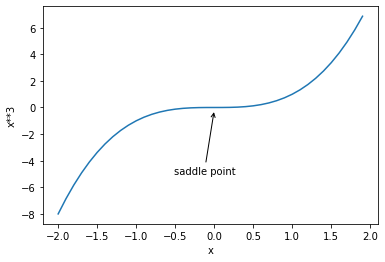

In [49]:
fig = plt.plot(x, y)[0]
fig.axes.annotate('saddle point', xytext=(-0.52, -5), 
                  arrowprops=dict(arrowstyle='->'), xy=(0, -0.2))
plt.xlabel('x')
plt.ylabel('x**3')

&emsp;&emsp;进一步的，我们来看下鞍点是如何影响梯度下降过程的。首先是由损失函数到梯度计算表达式的过程，由于损失函数只有一个参数，所以梯度表达式为：

$$f'(x) = 3x^2$$

我们可以定义该函数、导函数的函数及轨迹绘制函数

In [53]:
# x**3函数
def f_2(x):
    return np.power(x, 3)

In [52]:
f_2(-1)

-1

In [54]:
# x**3导函数
def f_gd_2(x):
    return (3*np.power(x, 2))

In [55]:
f_gd_2(-1)

3

In [56]:
# 梯度更新函数
def gd_2(lr = 0.05, itera_times = 200, w = 1):
    """
    梯度下降计算函数
    :param lr: 学习率
    :param itera_times：迭代次数
    :param w：参数初始取值
    :return results：每一轮迭代的参数计算结果列表
    """                              
    results = [w]
    for i in range(itera_times):
        w -= lr * f_gd_2(w)              # 梯度计算公式
        results.append(w)
    return results

当我们在以0.05作为学习率，参数初始值为1，迭代5000轮时参数每一轮迭代后参数的计算结果如下：

In [62]:
res = gd_2(itera_times=5000)
res[-1]

0.0013297766246039373

In [63]:
def show_trace_2(res):
    """
    梯度下降轨迹绘制函数
    """
    f_line = np.arange(-1, 2, 0.01)
    plt.plot(f_line, [f_2(x) for x in f_line])
    plt.plot(res, [f_2(x) for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('Loss(x)')

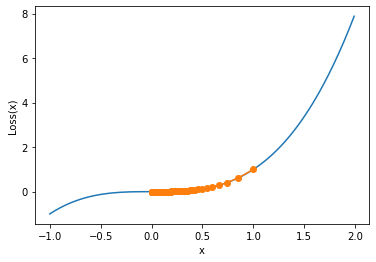

In [64]:
show_trace_2(res)

同样，梯度下降无法跨越鞍点抵达更小值的点，并且我们判断5000次迭代后参数点的梯度已经非常小了：

In [66]:
f_gd_2(res[-1])

5.304917614029122e-06

我们可以绘制一个包含了鞍点的二维图像进行观察：

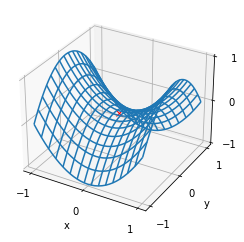

In [87]:
x, y = np.mgrid[-1:1:31j,-1:1:31j]
z = x**2- y**2
ax = plt.axes(projection='3d')
ax.plot_wireframe(x, y, z,**{'rstride':2,'cstride':2})
ax.plot([0],[0],[0],'rx')
ticks =[-1,0,1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y')

> 指的注意的是，在实际情况中，鞍点出现的频率高于局部最小值点。

### 3.梯度下降算法本质与改善方法

&emsp;&emsp;根据局部最小值和鞍点的讨论，我们不难发现梯度下降的本质作用其实是让参数点移动到梯度为0的点，当损失函数是严格意义的凸函数时，梯度为0的点就是全域最小值点，但如果损失函数不是凸函数，那么梯度为0的点就有可能是局部最小值点或者鞍点。此时受到局部最小值点或者鞍点梯度为0的影响，梯度下降无法从该点移出。尽管大多数线性模型的损失函数都是凸函数，但很多复杂机器学习模型所构建的损失函数都不一定是严格凸函数，要避免局部最小值点或者鞍点陷阱，我们就必须在梯度下降算法基础上进行改进。有一种最基础也是最通用的改进办法，就是每次在构建损失函数的时候代入一小部分数据，从而让参数有机会跳出陷阱，这就是所谓的随机梯度下降和小批量梯度下降。关于这两种改进办法的计算流程和实际效果，我们将在下一节课详细讨论。